In [ ]:
# !pip uninstall tidyzoning -y
# !pip install git+https://github.com/HOUPU1993/tidyzoning.git

Found existing installation: tidyzoning 0.1.0
Uninstalling tidyzoning-0.1.0:
  Successfully uninstalled tidyzoning-0.1.0
  Cloning https://github.com/HOUPU1993/tidyzoning.git to c:\users\admin\appdata\local\temp\pip-req-build-54rder3w
  Resolved https://github.com/HOUPU1993/tidyzoning.git to commit 9effac3124c0e956c8f51ed4ca2001d41cff68e9
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tidyzoning: filename=tidyzoning-0.1.0-py3-none-any.whl size=44235 sha256=7e5eb6cf2ccbba661abfbc9281eae90bf34d5a7a509356c8176e47ef0a6583f6
  Stored in directory: C:\Users\Admin\AppData\Local\Temp\pip-ephem-wheel-cache-9kz9uuow\wheels\f4\29\51\e431eb95e0bf6589310375ce483daada9c916a6f65f3b65a8f
Successfully built tidyzoning


  Running command git clone --filter=blob:none --quiet https://github.com/HOUPU1993/tidyzoning.git 'C:\Users\Admin\AppData\Local\Temp\pip-req-build-54rder3w'


In [ ]:
# pip install pandas==2.1.4 geopandas==0.14.2

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from shapely.geometry import Point
from shapely.geometry import box

from joblib import Parallel, delayed
from tqdm import tqdm

# input my libraries
from tidyzoning import find_district_idx
from tidyzoning import find_bldg_type
from tidyzoning import check_land_use
from tidyzoning import get_zoning_req
from tidyzoning import check_fl_area
from tidyzoning import check_far
from tidyzoning import check_height
from tidyzoning import check_stories
from tidyzoning import check_bedrooms
from tidyzoning import check_lot_coverage
from tidyzoning import check_unit_density
from tidyzoning import add_setbacks
from tidyzoning import get_buildable_area
from tidyzoning import zoning_analysis_pipeline
from tidyzoning import unify_tidybuilding
from tidyzoning import filter_constraints
from tidyzoning import check_zoning_process
from tidyzoning import parcels_in_zoning
from tidyzoning import parcel_in_confidence
from tidyzoning import generate_parcel_info

from tidyzoning.check_footprint import check_footprint
from tidyzoning.check_unit_size import check_unit_size

# Read files

## Read tidyzoning files

In [3]:
'''read the tidyzoning file'''

# Set the directory path
folder_path = r"C:\Users\Admin\Desktop\New folder (6)/final_ozfs_files"
# Get all GeoJSON files
geojson_files = [f for f in os.listdir(folder_path) if f.endswith('.geojson')]
# Read and merge all GeoJSON files
gdfs = [gpd.read_file(os.path.join(folder_path, file)) for file in geojson_files]
tidyzoning = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
tidyzoning = tidyzoning.to_crs(3857)
# Remove rows where geometry is None
tidyzoning = tidyzoning[tidyzoning["geometry"].notnull()].reset_index(drop=True)
tidyzoning

c:\Users\Admin\anaconda3\envs\houpu_py\lib\site-packages\geopandas\geoseries.py:766: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


,dist_info,lot_constraints,structure_constraints,other_constraints,geometry
0,"{'muni_name': 'Addison', 'county_name': 'Dalla...","{'lot_size': [{'unit': 'acres', 'use_name': '1...","{'setback_front': [{'unit': 'feet', 'use_name'...","{'parking_uncovered': [{'unit': 'stalls', 'use...","MULTIPOLYGON (((-10780184.101 3887684.743, -10..."
1,"{'muni_name': 'Addison', 'county_name': 'Dalla...","{'lot_size': [{'unit': 'acres', 'use_name': '1...","{'setback_front': [{'unit': 'feet', 'use_name'...","{'parking_uncovered': [{'unit': 'stalls', 'use...","MULTIPOLYGON (((-10777090.621 3888246.808, -10..."
2,"{'muni_name': 'Addison', 'county_name': 'Dalla...","{'lot_size': [{'unit': 'acres', 'use_name': ['...","{'setback_front': [{'unit': 'feet', 'use_name'...","{'parking_uncovered': [{'unit': 'stalls', 'use...","MULTIPOLYGON (((-10778516.328 3891864.967, -10..."
3,"{'muni_name': 'Addison', 'county_name': 'Dalla...",[ ],[ ],[ ],"MULTIPOLYGON (((-10781846.642 3887084.891, -10..."
4,"{'muni_name': 'Addison', 'county_name': 'Dalla...",[ ],[ ],[ ],"MULTIPOLYGON (((-10778798.181 3888383.694, -10..."
...,...,...,...,...,...
2329,"{'muni_name': 'Wylie', 'county_name': 'Collin'...",[ ],[ ],[ ],"MULTIPOLYGON (((-10744220.278 3899289.322, -10..."
2330,"{'muni_name': 'Wylie', 'county_name': 'Collin'...","{'lot_size': [{'unit': 'acres', 'use_name': 'P...",[ ],[ ],"MULTIPOLYGON (((-10743426.110 3892465.028, -10..."
2331,"{'muni_name': 'Wylie', 'county_name': 'Collin'...",[ ],[ ],[ ],"POLYGON ((-10746541.793 3897876.291, -10746589..."
2332,"{'muni_name': 'Wylie', 'county_name': 'Collin'...",[ ],"{'setback_front': [{'unit': 'feet', 'use_name'...","{'parking_uncovered': [{'unit': 'stalls', 'use...","POLYGON ((-10746536.928 3896835.654, -10746535..."


## Read tidyparcel files

In [5]:
# import geopandas as gpd
# import os
# import pandas as pd

# # Use raw string for path to avoid escape sequence issues
# folder_path = r"C:\Users\Admin\Desktop\New folder (6)\tidyparcel_all_counties_raw"
# gdfs = []

# for filename in os.listdir(folder_path):
#     if filename.endswith(".geojson"):
#         file_path = os.path.join(folder_path, filename)
#         gdf = gpd.read_file(file_path)
        
#         source_name = os.path.splitext(filename)[0]
#         gdf["parcel_id"] = f"{source_name}_" + gdf["parcel_id"].astype(str)
        
#         gdfs.append(gdf)

# # Combine all GeoDataFrames
# combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# # Set CRS if you're sure; otherwise, better to check each file's CRS
# combined_gdf = combined_gdf.set_crs(epsg=3857, allow_override=True)

# # Save combined GeoDataFrame
# output_path = r"C:\Users\Admin\Desktop\New folder (6)\tidyparcel_all_counties_raw\combined_raw_parcels.geojson"
# combined_gdf.to_file(output_path, driver="GeoJSON")

In [ ]:
# output_path = r"C:\Users\Admin\Desktop\New folder (6)\tidyparcel_all_counties_raw\combined_raw_parcels.geojson"
# combined_gdf = gpd.read_file(output_path)
# combined_gdf

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,50_threshold,num_edges,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry
0,2577028,R-8753-003-0250-1,Collin_County_combined_parcel_1,1710 WHITE MOUNTAIN WAY,R,A1,regular inside parcel,True,White Mountain Way,1.209347,True,4,8.265015,True,1.964345,0.194206,78.578503,30.796944,Interior side,"LINESTRING (-10746210.594 3921290.518, -107462..."
1,2577028,R-8753-003-0250-1,Collin_County_combined_parcel_1,1710 WHITE MOUNTAIN WAY,R,A1,regular inside parcel,True,White Mountain Way,1.209347,True,4,8.265015,True,0.335557,0.194206,8.098818,52.090551,rear,"LINESTRING (-10746226.155 3921327.995, -107462..."
2,2577028,R-8753-003-0250-1,Collin_County_combined_parcel_1,1710 WHITE MOUNTAIN WAY,R,A1,regular inside parcel,True,White Mountain Way,1.209347,True,4,8.265015,True,-1.282980,0.194206,84.636517,33.260657,Interior side,"LINESTRING (-10746206.092 3921334.992, -107461..."
3,2577028,R-8753-003-0250-1,Collin_County_combined_parcel_1,1710 WHITE MOUNTAIN WAY,R,A1,regular inside parcel,True,White Mountain Way,1.209347,True,4,8.265015,False,-2.803135,0.194206,8.265015,12.015904,front,"LINESTRING (-10746194.593 3921296.151, -107461..."
4,2577028,R-8753-003-0250-1,Collin_County_combined_parcel_1,1710 WHITE MOUNTAIN WAY,R,A1,regular inside parcel,True,White Mountain Way,1.209347,True,4,8.265015,False,-2.803135,0.194206,8.265015,12.015904,centroid,POINT (-10746209.665 3921313.270)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16114525,766738,R2747.0024.00,Wise_County_combined_parcel_9999,0 PR 1735,NaN,NaN,duplicated address,True,Pvt Rd 1735,1.363193,True,5,9.792967,False,-1.755471,3.122710,80.500838,57.145517,Exterior side,"LINESTRING (-10896527.859 3930452.265, -108965..."
16114526,766738,R2747.0024.00,Wise_County_combined_parcel_9999,0 PR 1735,NaN,NaN,duplicated address,True,Pvt Rd 1735,1.363193,True,5,9.792967,False,-0.120689,3.122710,5.833096,104.098579,rear,"LINESTRING (-10896554.688 3930455.519, -108965..."
16114527,766738,R2747.0024.00,Wise_County_combined_parcel_9999,0 PR 1735,NaN,NaN,duplicated address,True,Pvt Rd 1735,1.363193,True,5,9.792967,False,1.382720,3.122710,80.305900,82.932135,Exterior side,"LINESTRING (-10896563.239 3930410.593, -108965..."
16114528,766738,R2747.0024.00,Wise_County_combined_parcel_9999,0 PR 1735,NaN,NaN,duplicated address,True,Pvt Rd 1735,1.363193,True,5,9.792967,False,1.683186,3.122710,82.478636,37.130942,Exterior side,"LINESTRING (-10896557.976 3930363.962, -108965..."


### filted parcels within tidyzoning and confidence


In [ ]:
# # Generate the tidyparcel based on the tidyzoning geometry
# tidyparcel_fp = r"C:\Users\Admin\Desktop\New folder (6)\Dallas_County_combined_parcel.geojson"
# output_fp = r"C:\Users\Admin\Desktop\New folder (6)\tidyparcel_filtered.geojson"

# # Assuming tidyzoning is already loaded and in the correct CRS
# filtered = parcels_in_zoning(tidyparcel_fp, tidyzoning, output_fp=output_fp)

In [5]:
output_fp = r"C:\Users\Admin\Desktop\New folder (6)\tidyparcel_filtered_all.geojson"

# Create union of zoning geometries
tidyzoning_union = tidyzoning.dissolve().unary_union
tidyzoning_union = gpd.GeoDataFrame(geometry=[tidyzoning_union], crs=tidyzoning.crs)

# Filter centroids and spatial join
centroids = combined_gdf[combined_gdf['side'] == 'centroid']
centroids_with_zoning = gpd.sjoin(centroids, tidyzoning_union, how='inner', predicate='within')

# Get valid ids
valid_ids = centroids_with_zoning[['Prop_ID', 'parcel_id']].drop_duplicates()

# Filter tidyparcel using valid ids
filtered = combined_gdf.merge(valid_ids, on=['Prop_ID', 'parcel_id'], how='inner')

filtered.to_file(output_fp, driver='GeoJSON')

In [ ]:
# unique_parcels = filtered['parcel_id'].unique()
# sampled_parcels = pd.Series(unique_parcels).sample(frac=0.25, random_state=42)
# filtered_25 = filtered[filtered['parcel_id'].isin(sampled_parcels)]
# confident_tidyparcel_25 = parcel_in_confidence(filtered_25)
# confident_tidyparcel_25.to_file(r"C:\Users\Admin\Desktop\New folder (6)\confident_tidyparcel_25.geojson", driver='GeoJSON')
# confident_tidyparcel_25

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,50_threshold,num_edges,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry
10,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,True,4,0.201639,True,-1.571972,-0.006727,89.681925,36.761265,Interior side,"LINESTRING (-10768051.845 3919309.968, -107680..."
11,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,True,4,0.201639,True,-0.003207,-0.006727,0.201640,62.382758,rear,"LINESTRING (-10768069.990 3919310.026, -107680..."
12,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,True,4,0.201639,True,1.569623,-0.006727,89.681813,36.697407,Interior side,"LINESTRING (-10768070.050 3919258.718, -107680..."
13,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,True,4,0.201639,False,3.138385,-0.006727,0.201639,11.075914,front,"LINESTRING (-10768051.905 3919258.660, -107680..."
14,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,True,4,0.201639,False,3.138385,-0.006727,0.201639,11.075914,centroid,POINT (-10768060.948 3919284.343)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8787348,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,3.136105,1.559195,89.649721,80.348340,Exterior side,"LINESTRING (-10875534.040 3942172.280, -108756..."
8787349,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,-1.576295,1.559195,0.349634,11.077549,front,"LINESTRING (-10875533.784 3942218.868, -108755..."
8787350,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,1.025032,1.559195,30.605303,135.931720,rear,"LINESTRING (-10875672.867 3942173.042, -108756..."
8787351,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,-0.005499,1.559195,89.650397,66.757312,Exterior side,"LINESTRING (-10875644.667 3942219.477, -108755..."


In [ ]:
# tidyparcel_25 = generate_parcel_info(confident_tidyparcel_25, tidyzoning)
# tidyparcel_25.to_csv(r"C:\Users\Admin\Desktop\New folder (6)\tidyparcel_25.csv", index=False)
# tidyparcel_25

Processing parcels: 100%|██████████| 345459/345459 [4:25:14<00:00, 21.71it/s]  


,Prop_ID,parcel_id,Parcel_label,lot_width,lot_depth,lot_area,zoning_id
0,2747493,Collin_County_combined_parcel_10000,regular inside parcel,59.531804,168.332143,10021.078315,1318
1,2702267,Collin_County_combined_parcel_100028,special parcel_standard,110.678094,186.682872,20692.418256,1462
2,2082442,Collin_County_combined_parcel_100030,regular inside parcel,90.844054,184.225661,16126.840163,1318
3,2129279,Collin_County_combined_parcel_100049,regular inside parcel,106.160376,144.973232,15328.346858,1451
4,1262715,Collin_County_combined_parcel_100067,regular corner parcel,87.430731,138.294001,12090.284350,412
...,...,...,...,...,...,...,...
345345,783763,Wise_County_combined_parcel_9058,regular inside parcel,265.827398,337.953507,69825.308228,66
345346,783634,Wise_County_combined_parcel_9195,special parcel_standard,326.682317,214.367352,60946.955371,169
345347,755021,Wise_County_combined_parcel_9452,regular corner parcel,89.568826,167.983035,15045.994857,171
345348,753256,Wise_County_combined_parcel_9590,regular corner parcel,125.506837,180.139070,22608.608389,270


### Generate whole dataset

In [6]:
confident_tidyparcel = parcel_in_confidence(filtered)
confident_tidyparcel.to_file(r"C:\Users\Admin\Desktop\New folder (6)\confident_tidyparcel.geojson", driver='GeoJSON')
confident_tidyparcel

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,50_threshold,num_edges,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry
0,2577028,R-8753-003-0250-1,Collin_County_combined_parcel_1,1710 WHITE MOUNTAIN WAY,R,A1,regular inside parcel,True,White Mountain Way,1.209347,True,4,8.265015,True,1.964345,0.194206,78.578503,30.796944,Interior side,"LINESTRING (-10746210.594 3921290.518, -107462..."
1,2577028,R-8753-003-0250-1,Collin_County_combined_parcel_1,1710 WHITE MOUNTAIN WAY,R,A1,regular inside parcel,True,White Mountain Way,1.209347,True,4,8.265015,True,0.335557,0.194206,8.098818,52.090551,rear,"LINESTRING (-10746226.155 3921327.995, -107462..."
2,2577028,R-8753-003-0250-1,Collin_County_combined_parcel_1,1710 WHITE MOUNTAIN WAY,R,A1,regular inside parcel,True,White Mountain Way,1.209347,True,4,8.265015,True,-1.282980,0.194206,84.636517,33.260657,Interior side,"LINESTRING (-10746206.092 3921334.992, -107461..."
3,2577028,R-8753-003-0250-1,Collin_County_combined_parcel_1,1710 WHITE MOUNTAIN WAY,R,A1,regular inside parcel,True,White Mountain Way,1.209347,True,4,8.265015,False,-2.803135,0.194206,8.265015,12.015904,front,"LINESTRING (-10746194.593 3921296.151, -107461..."
4,2577028,R-8753-003-0250-1,Collin_County_combined_parcel_1,1710 WHITE MOUNTAIN WAY,R,A1,regular inside parcel,True,White Mountain Way,1.209347,True,4,8.265015,False,-2.803135,0.194206,8.265015,12.015904,centroid,POINT (-10746209.665 3921313.270)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10897415,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,3.136105,1.559195,89.649721,80.348340,Exterior side,"LINESTRING (-10875534.040 3942172.280, -108756..."
10897416,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,-1.576295,1.559195,0.349634,11.077549,front,"LINESTRING (-10875533.784 3942218.868, -108755..."
10897417,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,1.025032,1.559195,30.605303,135.931720,rear,"LINESTRING (-10875672.867 3942173.042, -108756..."
10897418,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,-0.005499,1.559195,89.650397,66.757312,Exterior side,"LINESTRING (-10875644.667 3942219.477, -108755..."


In [7]:
tidyparcel = generate_parcel_info(confident_tidyparcel, tidyzoning)
tidyparcel.to_csv(r"C:\Users\Admin\Desktop\New folder (6)\tidyparcel.csv", index=False)
tidyparcel

Processing parcels:   4%|▍         | 75907/1697771 [3:13:22<60:11:56,  7.48it/s] 

: 

: 

## Read tidyparcel

In [ ]:
confident_tidyparcel = gpd.read_file(r"C:\Users\Admin\Desktop\New folder (6)\confident_tidyparcel.geojson")
confident_tidyparcel = confident_tidyparcel.to_crs(3857)
confident_tidyparcel

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,50_threshold,num_edges,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry
0,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,True,4,0.201639,True,-1.571972,-0.006727,89.681925,36.761265,Interior side,"LINESTRING (-10768051.845 3919309.968, -107680..."
1,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,True,4,0.201639,True,-0.003207,-0.006727,0.201640,62.382758,rear,"LINESTRING (-10768069.990 3919310.026, -107680..."
2,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,True,4,0.201639,True,1.569623,-0.006727,89.681813,36.697407,Interior side,"LINESTRING (-10768070.050 3919258.718, -107680..."
3,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,True,4,0.201639,False,3.138385,-0.006727,0.201639,11.075914,front,"LINESTRING (-10768051.905 3919258.660, -107680..."
4,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,True,4,0.201639,False,3.138385,-0.006727,0.201639,11.075914,centroid,POINT (-10768060.948 3919284.343)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744427,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,3.136105,1.559195,89.649721,80.348340,Exterior side,"LINESTRING (-10875534.040 3942172.280, -108756..."
1744428,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,-1.576295,1.559195,0.349634,11.077549,front,"LINESTRING (-10875533.784 3942218.868, -108755..."
1744429,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,1.025032,1.559195,30.605303,135.931720,rear,"LINESTRING (-10875672.867 3942173.042, -108756..."
1744430,768605,S0060.0663.00,Wise_County_combined_parcel_9946,616 S WICKHAM ST,NaN,NaN,regular corner parcel,True,Wickham St,1.296870,True,4,0.349634,False,-0.005499,1.559195,89.650397,66.757312,Exterior side,"LINESTRING (-10875644.667 3942219.477, -108755..."


In [ ]:
tidyparcel = pd.read_csv(r"C:\Users\Admin\Desktop\New folder (6)\tidyparcel.csv")
tidyparcel

C:\Users\Admin\AppData\Local\Temp\ipykernel_26880\2346541542.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tidyparcel = pd.read_csv(r"C:\Users\Admin\Desktop\New folder (6)\tidyparcel_25.csv")


,Prop_ID,parcel_id,Parcel_label,lot_width,lot_depth,lot_area,zoning_id
0,2747493,Collin_County_combined_parcel_10000,regular inside parcel,59.531804,168.332143,10021.078315,1318
1,2702267,Collin_County_combined_parcel_100028,special parcel_standard,110.678094,186.682872,20692.418256,1462
2,2082442,Collin_County_combined_parcel_100030,regular inside parcel,90.844054,184.225661,16126.840163,1318
3,2129279,Collin_County_combined_parcel_100049,regular inside parcel,106.160376,144.973232,15328.346858,1451
4,1262715,Collin_County_combined_parcel_100067,regular corner parcel,87.430731,138.294001,12090.284350,412
...,...,...,...,...,...,...,...
345345,783763.0,Wise_County_combined_parcel_9058,regular inside parcel,265.827398,337.953507,69825.308228,66
345346,783634.0,Wise_County_combined_parcel_9195,special parcel_standard,326.682317,214.367352,60946.955371,169
345347,755021.0,Wise_County_combined_parcel_9452,regular corner parcel,89.568826,167.983035,15045.994857,171
345348,753256.0,Wise_County_combined_parcel_9590,regular corner parcel,125.506837,180.139070,22608.608389,270


### Generate the tidyparcel info datasets

In [ ]:
# import math
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import box, LineString
# from shapely.ops import unary_union, polygonize
# from shapely.affinity import rotate

# '''present the original & rotated rectangle with different colors'''
# rect = box(-5, -2, 5, 2)  # width=10, height=4
# rotated_rect = rotate(rect, 30, origin='centroid', use_radians=False)
# coords = list(rotated_rect.exterior.coords)

# # Define sides
# exterior = LineString([coords[0], coords[1]])        
# front = LineString([coords[1], coords[2]])    
# interior = LineString([coords[2], coords[3]])       
# rear = LineString([coords[3], coords[0]])    

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# x, y = rect.exterior.xy
# ax.plot(x, y, color="black", label="Rectangle")

# # Plot each side with a different color
# for name, side, color in [
#     ("rear", rear, "blue"),
#     ("exterior", exterior, "red"),
#     ("front", front, "green"),
#     ("interior", interior, "orange")
# ]:
#     sx, sy = side.xy
#     ax.plot(sx, sy, color=color, linewidth=3, label=name)

# ax.set_aspect("equal")
# ax.legend()
# plt.title("Labeled Sides of Rectangle")
# plt.show()



# '''calculated the angle of rotation'''
# front_centroid = front.centroid
# rear_centroid = rear.centroid

# dx = rear_centroid.x - front_centroid.x
# dy = rear_centroid.y - front_centroid.y

# angle = math.degrees(math.atan2(dy, dx))
# angle



# '''prensent the adjusted rectangular'''
# corrected_rect = rotate(rotated_rect, -angle, origin='centroid', use_radians=False)

# fig, ax = plt.subplots()

# # Original tilted one
# x, y = rotated_rect.exterior.xy
# ax.plot(x, y, label="Rotated (+30°)", color="red")

# # After correction
# x, y = corrected_rect.exterior.xy
# ax.plot(x, y, label="Corrected (Aligned)", color="green")

# ax.axis("equal")
# ax.legend()
# plt.title("Geometry Aligned with Horizontal Axis")
# plt.show()


## Read the tidybuilding file

In [5]:
file_path = r"C:\Users\Admin\Desktop\New folder (6)\tidybuilding\4_fam_tall/"
tidybuilding_4_fam = unify_tidybuilding(file_path)
tidybuilding_4_fam

,stories,height,width,depth,height_eave,type,gross_fl_area,net_fl_area,max_unit_size,min_unit_size,mean_unit_size,total_bedrooms,total_units,footprint,units_2bed,units_2bed_minsize,units_2bed_maxsize,units_floor1,units_floor2,units_floor3
0,3,40,32,60,40,4_family,5000,4712,1178,1178,1178,8,4,1920,4,1178,1178,1,1,1


## Visulize the tidyparcel and tidyzoning

In [ ]:
# import folium

# base_map = tidyparcel.explore(column='side')

# tidyzoning.explore(
#     m=base_map, 
#     alpha=0.2,   
#     color='blue' 
# )

## Create Different Functions

### `find_bldg_type` function

In [6]:
find_bldg_type_results = find_bldg_type(tidybuilding_4_fam)
find_bldg_type_results

'4_family'

### `get_zoning_req` function  
- `find_bldg_type` functiona is integrated internally.

In [7]:
get_zoning_req_results = get_zoning_req(tidybuilding_4_fam, tidyzoning.loc[[2]], tidyparcel[tidyparcel['parcel_id'] == 'Collin_County_combined_parcel_10000'])
get_zoning_req_results

,constraint_type,spec_type,min_value,max_value,unit,constraint_min_note,constraint_max_note,min_select,max_select
0,structure_constraints,setback_front,"[50, 30]",50,feet,"must match the setback of the neighbor, but no...",None,unique,None
1,structure_constraints,setback_side_int,"[20, 15]",None,feet,unique requirements not specified,None,unique,None
2,structure_constraints,setback_side_ext,"[50, 30]",None,feet,"must match the setback of the neighbor, but no...",None,unique,None
3,structure_constraints,setback_rear,25,None,feet,None,None,None,None
4,structure_constraints,stories,None,"[1, 2]",stories,None,1 story if it is within 150 ft of single famil...,None,unique
5,structure_constraints,unit_size,OZFS Error,None,square feet,None,None,None,None
6,other_constraints,parking_uncovered,10.0,None,stalls,None,None,None,None
7,lot_constraints,lot_size,1,None,acres,None,None,None,None


In [35]:
get_zoning_req_results = get_zoning_req(tidybuilding_4_fam, tidyzoning.loc[[2]], tidyparcel[tidyparcel['parcel_id'] == '10'])
get_zoning_req_results

,constraint_type,spec_type,min_value,max_value,unit,constraint_min_note,constraint_max_note,min_select,max_select
0,structure_constraints,setback_front,"[50, 30]",50,feet,"must match the setback of the neighbor, but no...",None,unique,None
1,structure_constraints,setback_side_int,OZFS Error,None,feet,None,None,None,None
2,structure_constraints,setback_side_ext,"[50, 30]",None,feet,"must match the setback of the neighbor, but no...",None,unique,None
3,structure_constraints,setback_rear,25,None,feet,None,None,None,None
4,structure_constraints,stories,None,"[1, 2]",stories,None,1 story if it is within 150 ft of single famil...,None,unique
5,structure_constraints,unit_size,OZFS Error,None,square feet,None,None,None,None
6,other_constraints,parking_uncovered,10.0,None,stalls,None,None,None,None
7,lot_constraints,lot_size,1,None,acres,None,None,None,None


In [9]:
get_zoning_req_results = get_zoning_req(tidybuilding_4_fam, tidyzoning.loc[[37]], tidyparcel[tidyparcel['parcel_id'] == '10'])
get_zoning_req_results

,constraint_type,spec_type,min_value,max_value,unit,constraint_min_note,constraint_max_note,min_select,max_select
0,structure_constraints,stories,None,"[2, 3]",stories,None,3 permitted if first floor is garage,None,unique
1,structure_constraints,unit_size,OZFS Error,None,square feet,None,None,None,None
2,structure_constraints,unit_density,None,18,du/acre,None,None,None,None
3,other_constraints,parking_uncovered,6.0,None,stalls,None,None,None,None
4,lot_constraints,lot_size,0.23,None,acres,None,None,None,None


### `Check` function

#### 01. `check_land_use` function
- `find_bldg_type` function is integrated internally.

In [7]:
check_land_use_results = check_land_use(tidybuilding_4_fam, tidyzoning)
check_land_use_results

,zoning_id,allowed
0,0,False
1,1,False
2,2,True
3,3,False
4,4,False
...,...,...
1768,1768,False
1769,1769,False
1770,1770,False
1771,1771,True


In [8]:
check_land_use_results['allowed'].value_counts()

allowed
False    1529
True      244
Name: count, dtype: int64

#### 02. `check_fl_area` function
- `get_zoning_req` function is integrated internally.

In [10]:
check_fl_area_result = check_fl_area(tidybuilding_4_fam, tidyzoning, tidyparcel[tidyparcel['parcel_id'] == '10'])
check_fl_area_result

,zoning_id,allowed,constraint_min_note,constraint_max_note
0,0,True,None,None
1,1,True,None,None
2,2,True,None,None
3,3,True,None,None
4,4,True,None,None
...,...,...,...,...
332,332,True,None,None
333,333,True,None,None
334,334,True,None,None
335,335,True,None,None


In [9]:
check_fl_area_result_all = check_zoning_process(tidybuilding_4_fam, tidyzoning, tidyparcel, check_fl_area, n_jobs=-1)
check_fl_area_result_all

Parallel Processing: 100%|██████████| 14068/14068 [11:03<00:00, 21.21it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


In [10]:
check_fl_area_result_all['allowed'].value_counts()

allowed
True    14068
Name: count, dtype: int64

#### 03. `check_far` function
- `get_zoning_req` function is integrated internally.

In [14]:
check_far_results = check_far(tidybuilding_4_fam, tidyzoning, tidyparcel[tidyparcel['parcel_id'] == '10'])
check_far_results

,zoning_id,allowed,constraint_min_note,constraint_max_note
0,0,True,None,None
1,1,True,None,None
2,2,True,None,None
3,3,True,None,None
4,4,True,None,None
...,...,...,...,...
332,332,True,None,None
333,333,True,None,None
334,334,True,None,None
335,335,True,None,None


In [11]:
check_far_result_all = check_zoning_process(tidybuilding_4_fam, tidyzoning, tidyparcel, check_far, n_jobs=-1)
check_far_result_all

Parallel Processing: 100%|██████████| 14068/14068 [11:24<00:00, 20.55it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


In [12]:
check_far_result_all['allowed'].value_counts()

allowed
True     13868
False      200
Name: count, dtype: int64

#### 04. `check_height` function
- `get_zoning_req` function is integrated internally.

In [18]:
check_height_result = check_height(tidybuilding_4_fam, tidyzoning, tidyparcel[tidyparcel['parcel_id'] == '10'])
check_height_result

,zoning_id,allowed,constraint_min_note,constraint_max_note
0,0,True,None,None
1,1,True,None,None
2,2,True,None,None
3,3,True,None,None
4,4,True,None,None
...,...,...,...,...
332,332,True,None,None
333,333,True,None,None
334,334,True,None,None
335,335,True,None,None


In [13]:
check_height_result_all = check_zoning_process(tidybuilding_4_fam, tidyzoning, tidyparcel, check_height, n_jobs=-1)
check_height_result_all

Parallel Processing:   0%|          | 0/14068 [00:00<?, ?it/s]

Parallel Processing: 100%|██████████| 14068/14068 [11:20<00:00, 20.66it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


In [14]:
check_height_result_all['allowed'].value_counts()

allowed
True     9247
False    4494
MAYBE     327
Name: count, dtype: int64

#### 05. `check_bedrooms` function
- `get_zoning_req` function is integrated internally.

In [22]:
check_bedrooms_result = check_bedrooms(tidybuilding_4_fam, tidyzoning, tidyparcel[tidyparcel['parcel_id'] == '10'])
check_bedrooms_result

,zoning_id,allowed,constraint_min_note,constraint_max_note
0,0,True,None,None
1,1,True,None,None
2,2,True,None,None
3,3,True,None,None
4,4,True,None,None
...,...,...,...,...
332,332,True,None,None
333,333,True,None,None
334,334,True,None,None
335,335,True,None,None


In [15]:
check_bedrooms_result_all = check_zoning_process(tidybuilding_4_fam, tidyzoning, tidyparcel, check_bedrooms, n_jobs=-1)
check_bedrooms_result_all

Parallel Processing:   0%|          | 0/14068 [00:00<?, ?it/s]

Parallel Processing: 100%|██████████| 14068/14068 [05:50<00:00, 40.13it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


In [16]:
check_bedrooms_result_all['allowed'].value_counts()

allowed
True    14068
Name: count, dtype: int64

#### 06. `check_lot_coverage` function
- `get_zoning_req` function is integrated internally.

In [26]:
check_lot_coverage_result = check_lot_coverage(tidybuilding_4_fam, tidyzoning, tidyparcel[tidyparcel['parcel_id'] == '10'])
check_lot_coverage_result

,zoning_id,allowed,constraint_min_note,constraint_max_note
0,0,True,None,None
1,1,True,None,None
2,2,True,None,None
3,3,True,None,None
4,4,True,None,None
...,...,...,...,...
332,332,True,None,None
333,333,True,None,None
334,334,True,None,None
335,335,True,None,None


In [17]:
check_lot_coverage_result_all = check_zoning_process(tidybuilding_4_fam, tidyzoning, tidyparcel, check_lot_coverage, n_jobs=-1)
check_lot_coverage_result_all

Parallel Processing: 100%|██████████| 14068/14068 [11:19<00:00, 20.70it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


In [18]:
check_lot_coverage_result_all['allowed'].value_counts()

allowed
True    14068
Name: count, dtype: int64

#### 07. `check_unit_density` function
- `get_zoning_req` function is integrated internally.

In [30]:
check_unit_density_result = check_unit_density(tidybuilding_4_fam, tidyzoning, tidyparcel[tidyparcel['parcel_id'] == '10'])
check_unit_density_result

,zoning_id,allowed,constraint_min_note,constraint_max_note
0,0,True,None,None
1,1,True,None,None
2,2,True,None,None
3,3,True,None,None
4,4,True,None,None
...,...,...,...,...
332,332,True,None,None
333,333,True,None,None
334,334,True,None,None
335,335,True,None,None


In [19]:
check_unit_density_result_all = check_zoning_process(tidybuilding_4_fam, tidyzoning, tidyparcel, check_unit_density, n_jobs=-1)
check_unit_density_result_all

Parallel Processing: 100%|██████████| 14068/14068 [06:10<00:00, 38.01it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


In [20]:
check_unit_density_result_all['allowed'].value_counts()

allowed
True    14068
Name: count, dtype: int64

#### 08. `check_unit_size` function
- `get_zoning_req` function is integrated internally.

In [34]:
check_unit_size_result = check_unit_size(tidybuilding_4_fam, tidyzoning, tidyparcel[tidyparcel['parcel_id'] == '10'])
check_unit_size_result

,zoning_id,allowed,constraint_min_note,constraint_max_note
0,0,True,None,None
1,1,True,None,None
2,2,True,None,None
3,3,True,None,None
4,4,True,None,None
...,...,...,...,...
332,332,True,None,None
333,333,True,None,None
334,334,True,None,None
335,335,True,None,None


In [21]:
check_unit_size_result_all = check_zoning_process(tidybuilding_4_fam, tidyzoning, tidyparcel, check_unit_size, n_jobs=-1)
check_unit_size_result_all

Parallel Processing: 100%|██████████| 14068/14068 [06:13<00:00, 37.70it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


In [22]:
check_unit_size_result_all['allowed'].value_counts()

allowed
True     13955
False      113
Name: count, dtype: int64

#### 09. `check_stories` function
- `get_zoning_req` function is integrated internally.

In [37]:
check_stories_result = check_stories(tidybuilding_4_fam, tidyzoning, tidyparcel[tidyparcel['parcel_id'] == '10'])
check_stories_result

,zoning_id,allowed,constraint_min_note,constraint_max_note
0,0,True,None,None
1,1,True,None,None
2,2,False,None,1 story if it is within 150 ft of single famil...
3,3,True,None,None
4,4,True,None,None
...,...,...,...,...
332,332,True,None,None
333,333,True,None,None
334,334,True,None,None
335,335,True,None,None


In [23]:
check_stories_result_all = check_zoning_process(tidybuilding_4_fam, tidyzoning, tidyparcel, check_stories, n_jobs=-1)
check_stories_result_all

Parallel Processing:   0%|          | 0/14068 [00:00<?, ?it/s]

Parallel Processing: 100%|██████████| 14068/14068 [06:05<00:00, 38.48it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


In [24]:
check_stories_result_all['allowed'].value_counts()

allowed
True     13113
False      805
MAYBE      150
Name: count, dtype: int64

### Statistics figure of allowed parcels in each check function

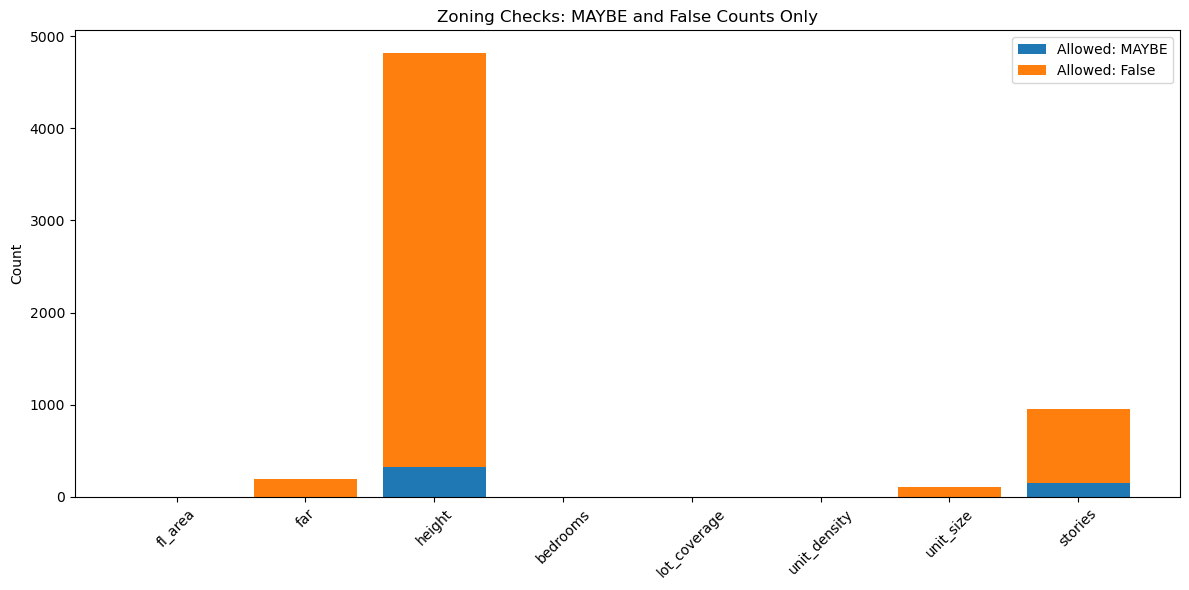

In [25]:
import matplotlib.pyplot as plt

# Place all check results
check_results = {
    "fl_area": check_fl_area_result_all,
    "far": check_far_result_all,
    "height": check_height_result_all,
    "bedrooms": check_bedrooms_result_all,
    "lot_coverage": check_lot_coverage_result_all,
    "unit_density": check_unit_density_result_all,
    "unit_size": check_unit_size_result_all,
    "stories": check_stories_result_all
}

# Summarize allowed status
summary = {
    "False": [],
    "MAYBE": [],
    "Label": []
}

for label, df in check_results.items():
    allowed_counts = df["allowed"].value_counts()
    summary["False"].append(allowed_counts.get(False, 0))
    summary["MAYBE"].append(allowed_counts.get("MAYBE", 0))
    summary["Label"].append(label)

# Plot
labels = summary["Label"]
x = range(len(labels))

fig, ax = plt.subplots(figsize=(12, 6))

# Stack: MAYBE and False
ax.bar(x, summary["MAYBE"], label='Allowed: MAYBE')
ax.bar(
    x,
    summary["False"],
    bottom=summary["MAYBE"],
    label='Allowed: False'
)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel("Count")
ax.set_title("Zoning Checks: MAYBE and False Counts Only")
ax.legend()

plt.tight_layout()
plt.show()

### `add_setbacks` function
- `get_zoning_req` function is integrated internally.

In [12]:
# Example usage:
add_setbacks_results = add_setbacks(tidybuilding_4_fam, tidyzoning.loc[[2]], tidyparcel[tidyparcel['parcel_id'] == 'Collin_County_combined_parcel_10000'], confident_tidyparcel[confident_tidyparcel['parcel_id'] == 'Collin_County_combined_parcel_10000'])
add_setbacks_results

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,...,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry,setback,unit
0,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,True,-1.571972,-0.006727,89.681925,36.761265,Interior side,"LINESTRING (-10768051.845 3919309.968, -107680...","[20, 15]",feet
1,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,True,-0.003207,-0.006727,0.201640,62.382758,rear,"LINESTRING (-10768069.990 3919310.026, -107680...",25,feet
2,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,True,1.569623,-0.006727,89.681813,36.697407,Interior side,"LINESTRING (-10768070.050 3919258.718, -107680...","[20, 15]",feet
3,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,False,3.138385,-0.006727,0.201639,11.075914,front,"LINESTRING (-10768051.905 3919258.660, -107680...","[50, 30]",feet


### `get_buildable_area` function
- `get_zoning_req` function is integrated internally.

In [13]:
# Example usage:
add_setbacks_results = add_setbacks(tidybuilding_4_fam, tidyzoning.loc[[2]], tidyparcel[tidyparcel['parcel_id'] == 'Collin_County_combined_parcel_10000'], confident_tidyparcel[confident_tidyparcel['parcel_id'] == 'Collin_County_combined_parcel_10000'])
add_setbacks_results

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,...,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry,setback,unit
0,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,True,-1.571972,-0.006727,89.681925,36.761265,Interior side,"LINESTRING (-10768051.845 3919309.968, -107680...","[20, 15]",feet
1,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,True,-0.003207,-0.006727,0.201640,62.382758,rear,"LINESTRING (-10768069.990 3919310.026, -107680...",25,feet
2,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,True,1.569623,-0.006727,89.681813,36.697407,Interior side,"LINESTRING (-10768070.050 3919258.718, -107680...","[20, 15]",feet
3,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,False,3.138385,-0.006727,0.201639,11.075914,front,"LINESTRING (-10768051.905 3919258.660, -107680...","[50, 30]",feet


In [14]:
get_buildable_area_result = get_buildable_area(add_setbacks_results)
get_buildable_area_result

,Prop_ID,parcel_id,buildable_geometry_relaxable,buildable_geometry_strict
0,2747493,Collin_County_combined_parcel_10000,POLYGON ((-10768065.467793169 3919267.84744810...,"POLYGON ((-10768063.937 3919273.939, -10768063..."


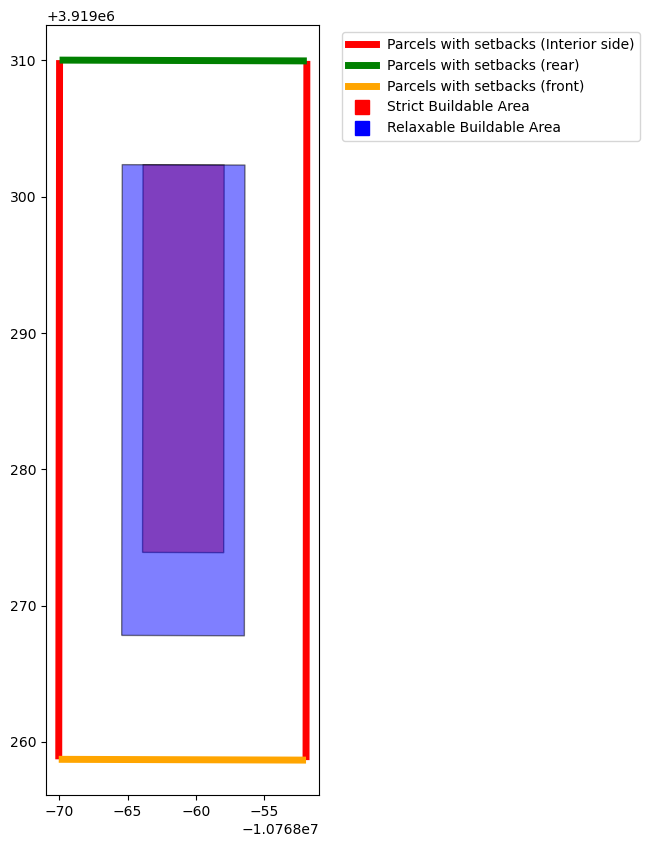

In [43]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Define a mapping from 'side' values to colors.
color_mapping = {
    'Interior side': 'red',
    'Exterior side': 'blue',
    'rear': 'green',
    'front': 'orange'
}

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the setbacks results by grouping based on the 'side' column.
for side, group in add_setbacks_results.groupby('side'):
    group.plot(
        ax=ax, 
        color=None, 
        alpha=1, 
        edgecolor=color_mapping.get(side, 'black'), 
        linewidth=5, 
        label=f'Parcels with setbacks ({side})'
    )

# Plot the strict buildable area.
strict_area = get_buildable_area_result.copy().set_geometry('buildable_geometry_strict')
strict_area.plot(
    ax=ax, 
    color='red', 
    alpha=0.5, 
    edgecolor='black', 
    label='Strict Buildable Area'
)

# Plot the relaxable buildable area.
relaxable_area = get_buildable_area_result.copy().set_geometry('buildable_geometry_relaxable')
relaxable_area.plot(
    ax=ax, 
    color='blue', 
    alpha=0.5, 
    edgecolor='black', 
    label='Relaxable Buildable Area'
)

# Create custom legend handles.
handles = []
# Add legend handles for each setbacks side.
for side in add_setbacks_results['side'].unique():
    color = color_mapping.get(side, 'black')
    handle = mlines.Line2D([], [], color=color, linewidth=5, label=f'Parcels with setbacks ({side})')
    handles.append(handle)
# Add handles for the buildable area layers.
handles.append(mlines.Line2D([], [], color='red', marker='s', markersize=10,
                             markerfacecolor='red', linestyle='None',
                             label='Strict Buildable Area'))
handles.append(mlines.Line2D([], [], color='blue', marker='s', markersize=10,
                             markerfacecolor='blue', linestyle='None',
                             label='Relaxable Buildable Area'))

ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(2.2, 1))
plt.show()

### `check_footprint()` function
- Based on Matt's Way

In [15]:
check_footprint_results = check_footprint(get_buildable_area_result, tidybuilding_4_fam)
check_footprint_results

Processing Parcels: 100%|██████████| 1/1 [00:00<00:00, 45.48it/s]


,Prop_ID,parcel_id,allowed
0,2747493,Collin_County_combined_parcel_10000,False


### Run Code by steps

### Run Code summariezed function

#### Statistic in each check function

##### Check the land use

In [23]:
from collections import Counter

# Extract uses_value, ensuring it is of list type
uses_values_list = tidyzoning['dist_info'].apply(
    lambda x: x.get('uses_permitted', {}).get('uses_value', [])
)

# Handle exceptional cases: if `uses_value` is a string, convert it to a list
cleaned_uses_values = uses_values_list.apply(lambda x: [x] if isinstance(x, str) else x)

# Calculate all unique uses_value
unique_uses_values = set(value for sublist in cleaned_uses_values for value in sublist)

# Count the occurrences of each uses_value
counts = Counter()
for uses in cleaned_uses_values:
    counts.update(uses)

# Create a DataFrame to calculate the percentage
counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
counts_df['percentage'] = counts_df['count'] / len(tidyzoning) * 100
counts_df

,count,percentage
1_family,114,40.569395
ADU,103,36.654804
2_family,45,16.014235
3_family,44,15.658363
4_family,45,16.014235
Townhome,48,17.081851
none,115,40.925267
Planned_Residential_Development,11,3.914591


##### Check the fl_area

In [24]:
fl_area_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'fl_area' in key.lower()} if isinstance(x, dict) else {}
)
fl_area_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

##### Check the height

In [25]:
height_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'height' in key.lower()} if isinstance(x, dict) else {}
)
height_constraints

0                                                     {}
1                                                     {}
2                                                     {}
3                                                     {}
4                                                     {}
                             ...                        
276                                                   {}
277                                                   {}
278                                                   {}
279    {'height': [{'unit': 'feet', 'use_name': '1_fa...
280                                                   {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_24888\1675141653.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='height', data=filtered_df, palette="Set3")


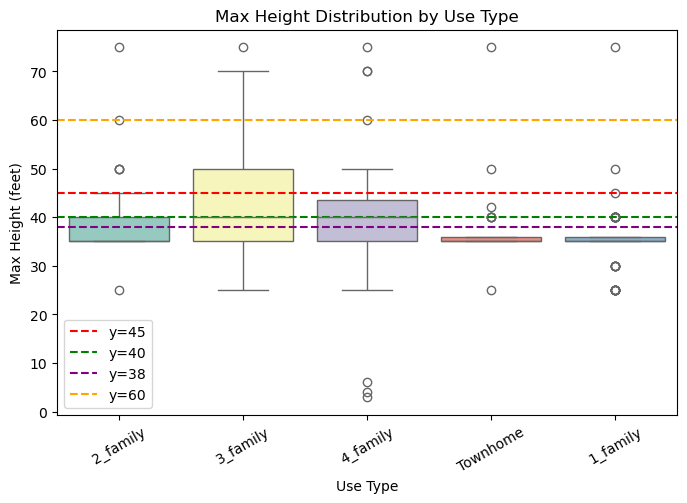

In [36]:
import seaborn as sns

# Step 1: Parse height data
height_data = []
for constraints in height_constraints:
    if isinstance(constraints, dict) and 'height' in constraints:
        for entry in constraints['height']:
            use_names = entry.get('use_name', [])
            max_val = entry.get('max_val')

            # Handle max_val: it could be a dictionary or a list
            if isinstance(max_val, list):  # Handle case where max_val is a list
                max_val = max_val[0] if len(max_val) > 0 else {}
            
            # Extract height value
            if isinstance(max_val, dict):
                if 'expression' in max_val:
                    height_value = max_val['expression']
                elif 'expressions' in max_val:
                    height_value = max(max_val['expressions'])  # Take the maximum value
                else:
                    height_value = None
            else:
                height_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if height_value:
                for use in use_names:
                    try:
                        height_data.append({'use_name': use, 'height': float(height_value)})
                    except ValueError:
                        pass  # Ignore values that cannot be converted

# Step 2: Convert to DataFrame
height_df = pd.DataFrame(height_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = height_df[height_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='height', data=filtered_df, palette="Set3")

# Step 5: Add reference lines
for y_value, color, label in zip([45, 40, 38, 60], ['red', 'green', 'purple', 'orange'], ['y=45', 'y=40', 'y=38', 'y=60']):
    plt.axhline(y=y_value, color=color, linestyle='--', label=label)

# Step 6: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Max Height (feet)")
plt.title("Max Height Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the bedrooms

In [37]:
bedrooms_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'bedrooms' in key.lower()} if isinstance(x, dict) else {}
)
bedrooms_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

##### Check the unit density

In [26]:
unit_density_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'unit_density' in key.lower()} if isinstance(x, dict) else {}
)
unit_density_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_24888\2265464215.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='unit_density', data=filtered_df, palette="Set3")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


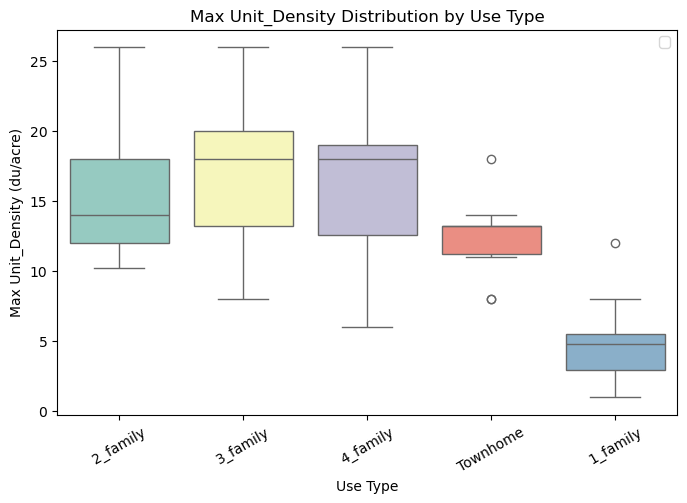

In [39]:
import seaborn as sns

# Step 1: Parse unit_density data
unit_density_data = []
for constraints in unit_density_constraints:
    if isinstance(constraints, dict) and 'unit_density' in constraints:
        for entry in constraints['unit_density']:
            use_names = entry.get('use_name', [])
            max_val = entry.get('max_val')

            # Handle max_val: it could be a dictionary or a list
            if isinstance(max_val, list):  # Handle case where max_val is a list
                max_val = max_val[0] if len(max_val) > 0 else {}
            
            # Extract unit_density value
            if isinstance(max_val, dict):
                if 'expression' in max_val:
                    unit_density_value = max_val['expression']
                elif 'expressions' in max_val:
                    unit_density_value = max(max_val['expressions'])  # Take the maximum value
                else:
                    unit_density_value = None
            else:
                unit_density_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if unit_density_value:
                for use in use_names:
                    try:
                        unit_density_data.append({'use_name': use, 'unit_density': float(unit_density_value)})
                    except ValueError:
                        pass  # Ignore values that cannot be converted

# Step 2: Convert to DataFrame
unit_density_df = pd.DataFrame(unit_density_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = unit_density_df[unit_density_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='unit_density', data=filtered_df, palette="Set3")

# Step 5: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Max Unit_Density (du/acre)")
plt.title("Max Unit_Density Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the unit size

In [27]:
unit_size_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'unit_size' in key.lower()} if isinstance(x, dict) else {}
)
unit_size_constraints

0      {'unit_size': [{'unit': 'square feet', 'use_na...
1      {'unit_size': [{'unit': 'square feet', 'use_na...
2      {'unit_size': [{'unit': 'square feet', 'use_na...
3                                                     {}
4                                                     {}
                             ...                        
276                                                   {}
277                                                   {}
278                                                   {}
279                                                   {}
280                                                   {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_24888\513548288.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='unit_size', data=filtered_df, palette="Set3")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


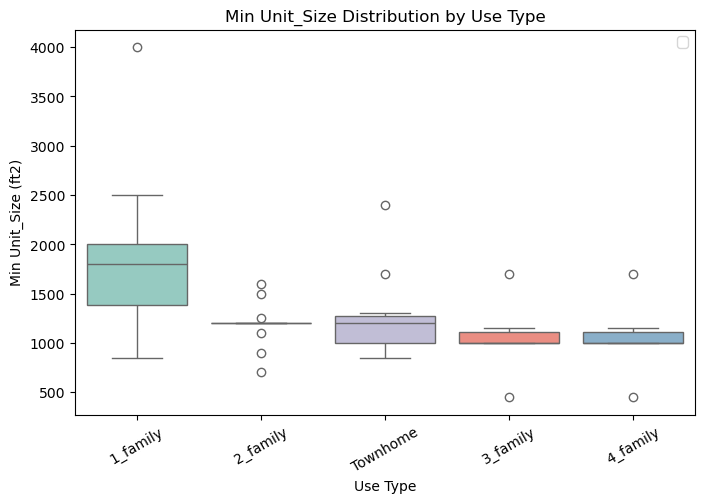

In [41]:
import seaborn as sns
import re

# Step 1: Parse unit_size data
unit_size_data = []
bedrooms = 6  # Default bedrooms=6

for constraints in unit_size_constraints:
    if isinstance(constraints, dict) and 'unit_size' in constraints:
        for entry in constraints['unit_size']:
            use_names = entry.get('use_name', [])
            min_val = entry.get('min_val')

            # Handle min_val: it could be a dictionary or a list
            if isinstance(min_val, list):  
                min_val = min_val[0] if len(min_val) > 0 else {}

            # Extract expression
            if isinstance(min_val, dict) and 'expression' in min_val:
                raw_expr = min_val['expression']
                
                # Skip "NA" values
                if raw_expr == 'NA':
                    continue
                
                # Handle "0/1 BR: 600; 2 BR: 800; 3BR: 1000"
                if re.search(r'3BR:\s*\d+', raw_expr):
                    match = re.search(r'3BR:\s*(\d+)', raw_expr)
                    unit_size_value = float(match.group(1)) if match else None
                
                # Handle "800 + 150 * bedrooms" calculation
                elif re.search(r'bedrooms', raw_expr):
                    try:
                        unit_size_value = eval(raw_expr.replace("bedrooms", str(bedrooms)))
                    except:
                        unit_size_value = None
                
                # Handle regular numeric values
                else:
                    try:
                        unit_size_value = float(raw_expr)
                    except ValueError:
                        unit_size_value = None
            else:
                unit_size_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if unit_size_value:
                for use in use_names:
                    try:
                        unit_size_data.append({'use_name': use, 'unit_size': unit_size_value})
                    except ValueError:
                        pass  # Ignore values that cannot be converted
                    
# Step 2: Convert to DataFrame
unit_size_df = pd.DataFrame(unit_size_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = unit_size_df[unit_size_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='unit_size', data=filtered_df, palette="Set3")

# Step 5: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Min Unit_Size (ft2)")
plt.title("Min Unit_Size Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the Far

In [28]:
far_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'far' in key.lower()} if isinstance(x, dict) else {}
)
far_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_24888\2235503832.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='far', data=filtered_df, palette="Set3")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


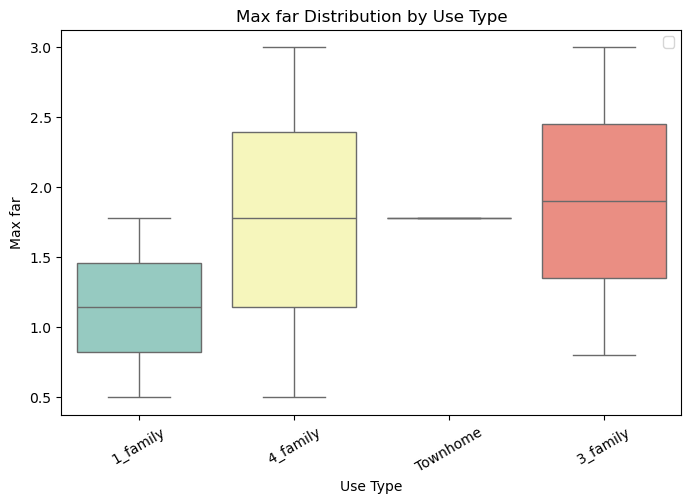

In [43]:
import seaborn as sns

# Step 1: Parse far data
far_data = []
for constraints in far_constraints:
    if isinstance(constraints, dict) and 'far' in constraints:
        for entry in constraints['far']:
            use_names = entry.get('use_name', [])
            max_val = entry.get('max_val')

            # Handle max_val: it could be a dictionary or a list
            if isinstance(max_val, list):  # Handle case where max_val is a list
                max_val = max_val[0] if len(max_val) > 0 else {}
            
            # Extract far value
            if isinstance(max_val, dict):
                if 'expression' in max_val:
                    far_value = max_val['expression']
                elif 'expressions' in max_val:
                    far_value = max(max_val['expressions'])  # Take the maximum value
                else:
                    far_value = None
            else:
                far_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if far_value:
                for use in use_names:
                    try:
                        far_data.append({'use_name': use, 'far': float(far_value)})
                    except ValueError:
                        pass  # Ignore values that cannot be converted

# Step 2: Convert to DataFrame
far_df = pd.DataFrame(far_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = far_df[far_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='far', data=filtered_df, palette="Set3")

# Step 5: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Max far")
plt.title("Max far Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the Lot_coverage

In [29]:
lot_coverage_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'lot_coverage' in key.lower()} if isinstance(x, dict) else {}
)
lot_coverage_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

In [7]:
tidybuilding_2_fam

,stories,height,width,depth,height_eave,type,gross_fl_area,fl_area,max_unit_size,min_unit_size,total_bedrooms,total_units,footprint,units_3bed,units_floor1,units_floor2,units_floor3
0,2.5,45,35,40,35,2_family,3200,3126,1563,1563,6,2,1400,2,2,0,0


### `zoning_analysis_pipeline` functions  

- 00.check_land_use
- 01.check_height
- 02.check_stories
- 03.check_unit_size
- 04.check_far
- 05.check_unit_density
- 06.check_bedrooms
- 07.check_lot_coverage
- 08.check_fl_area

In [ ]:
result_df = zoning_analysis_pipeline(tidybuilding_4_fam, tidyzoning, tidyparcel, confident_tidyparcel)
result_df

Parcel count: total 345350 parcels,
14068 passed land use check; others marked as check_land_use=False.
Percentage remaining: 4.07%.


Processing Allowed Parcels: 100%|██████████| 14068/14068 [18:20<00:00, 12.79it/s]


Number of parcels to run check_footprint after passing previous checks: 9204 (2.67% of total parcels)


Processing Parcels: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s],  3.98it/s]
Processing Parcels: 0it [00:00, ?it/s]    | 2467/9204 [10:58<27:53,  4.03it/s]
Processing Parcels: 100%|██████████| 1/1 [00:00<00:00, 66.32it/s]5,  3.99it/s]
Processing Parcels: 0it [00:00, ?it/s]▊   | 6306/9204 [28:13<12:24,  3.89it/s]
Processing Parcels: 100%|██████████| 1/1 [00:00<00:00, 998.17it/s],  4.05it/s]
Processing Parcels: 0it [00:00, ?it/s]█   | 6546/9204 [29:18<10:50,  4.09it/s]
Processing Parcels: 0it [00:00, ?it/s]█   | 6547/9204 [29:18<10:42,  4.14it/s]
Processing Parcels: 0it [00:00, ?it/s]█   | 6548/9204 [29:18<10:41,  4.14it/s]
Processing Parcels: 0it [00:00, ?it/s]█   | 6549/9204 [29:18<10:31,  4.20it/s]
Processing Parcels: 0it [00:00, ?it/s]█   | 6550/9204 [29:19<10:50,  4.08it/s]
Processing Parcels: 0it [00:00, ?it/s]█   | 6551/9204 [29:19<10:46,  4.10it/s]
Processing Parcels: 0it [00:00, ?it/s]█   | 6552/9204 [29:19<10:36,  4.17it/s]
Processing Parcels: 0it [00:00, ?it/s]█   | 6553/920

In [70]:
result_df

,Prop_ID,parcel_id,zoning_id,allowed,reason,check_process
0,2747493,Collin_County_combined_parcel_10000,1318,False,check_land_use,{'check_land_use': False}
1,2702267,Collin_County_combined_parcel_100028,1462,False,check_land_use,{'check_land_use': False}
2,2082442,Collin_County_combined_parcel_100030,1318,False,check_land_use,{'check_land_use': False}
3,2129279,Collin_County_combined_parcel_100049,1451,False,check_land_use,{'check_land_use': False}
4,1262715,Collin_County_combined_parcel_100067,412,False,check_land_use,{'check_land_use': False}
...,...,...,...,...,...,...
345345,783763.0,Wise_County_combined_parcel_9058,66,False,check_land_use,{'check_land_use': False}
345346,783634.0,Wise_County_combined_parcel_9195,169,False,check_footprint,"{'check_land_use': True, 'check_height': True,..."
345347,755021.0,Wise_County_combined_parcel_9452,171,False,check_land_use,{'check_land_use': False}
345348,753256.0,Wise_County_combined_parcel_9590,270,False,check_land_use,{'check_land_use': False}
